# 0. Loading packages

Uncomment cell below if not all necessary packages are installed

In [1]:
# Install necessary packages
# %pip install numpy
# %pip install matplotlib
# %pip install pandas
# %pip install seaborn
# %pip install scikit-learn
# %pip install missingno
# %pip install imblearn
# %pip install xgboost
# %pip install statsmodels

In [2]:
import warnings
warnings.filterwarnings('ignore')

import functions as fc

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
from scipy.fft import fft, ifft
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.deterministic import DeterministicProcess
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor, BaggingRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# 1. Loading data

In [3]:
train_data = pd.read_csv('Datasets/train.csv')
test_data = pd.read_csv('Datasets/test.csv')

test_data_pred_col = list(test_data['date_hour'])

# 2. Inspecting data

## 2.1 Showing datasets

In [4]:
train_data.head()

,date_hour,holiday,weathersit,temp,atemp,hum,windspeed,cnt
0,2011-01-01 00:00:00,0,1,0.24,0.2879,0.81,0.0,16
1,2011-01-01 01:00:00,0,1,0.22,0.2727,0.80,0.0,40
2,2011-01-01 02:00:00,0,1,0.22,0.2727,0.80,0.0,32
3,2011-01-01 03:00:00,0,1,0.24,0.2879,0.75,0.0,13
4,2011-01-01 04:00:00,0,1,0.24,0.2879,0.75,0.0,1


In [5]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16637 entries, 0 to 16636
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   date_hour   16637 non-null  object 
 1   holiday     16637 non-null  int64  
 2   weathersit  16637 non-null  int64  
 3   temp        16637 non-null  float64
 4   atemp       16637 non-null  float64
 5   hum         16637 non-null  float64
 6   windspeed   16637 non-null  float64
 7   cnt         16637 non-null  int64  
dtypes: float64(4), int64(3), object(1)
memory usage: 1.0+ MB


In [6]:
train_data.describe()

,holiday,weathersit,temp,atemp,hum,windspeed,cnt
count,16637.000000,16637.000000,16637.000000,16637.000000,16637.000000,16637.000000,16637.000000
mean,0.028671,1.415580,0.504745,0.482608,0.624756,0.190310,190.477009
std,0.166885,0.637298,0.192369,0.171557,0.193227,0.121915,182.026755
min,0.000000,1.000000,0.020000,0.000000,0.000000,0.000000,1.000000
25%,0.000000,1.000000,0.340000,0.333300,0.470000,0.104500,41.000000
50%,0.000000,1.000000,0.520000,0.500000,0.620000,0.194000,143.000000
75%,0.000000,2.000000,0.660000,0.621200,0.780000,0.253700,282.000000
max,1.000000,4.000000,1.000000,1.000000,1.000000,0.850700,977.000000


The datasets contains no missing data.

The columns in the dataset are predominantly of data types `int` or `float`, except for the `date_hour` column, which is of type `object`. This column will need to be converted to the `datetime` format for further analysis.

## 2.2 Inspecting individual columns

In [7]:
cols = ['holiday', 'weathersit', 'temp', 'atemp', 'hum', 'windspeed', 'cnt']

dv_train = fc.DataVisualizer(train_data)

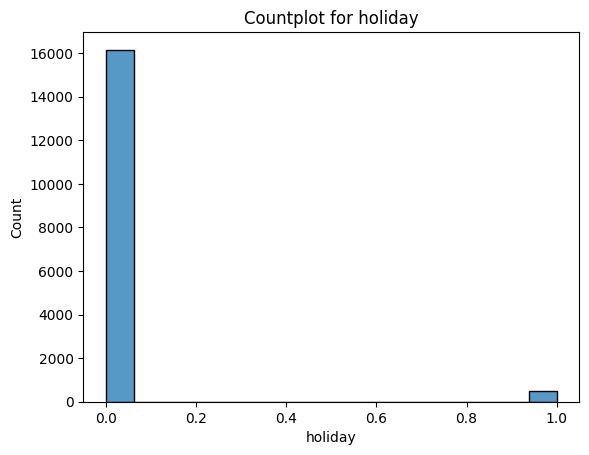

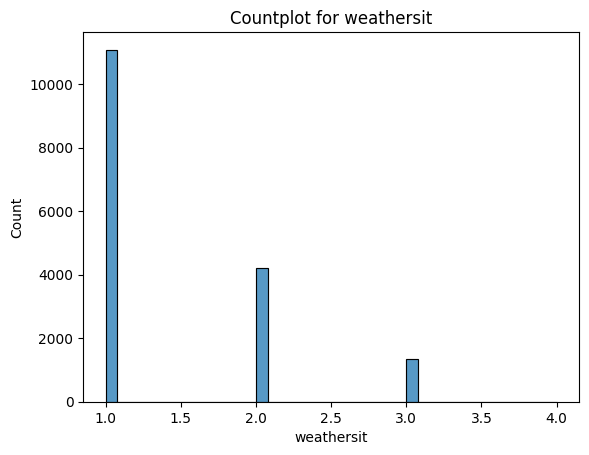

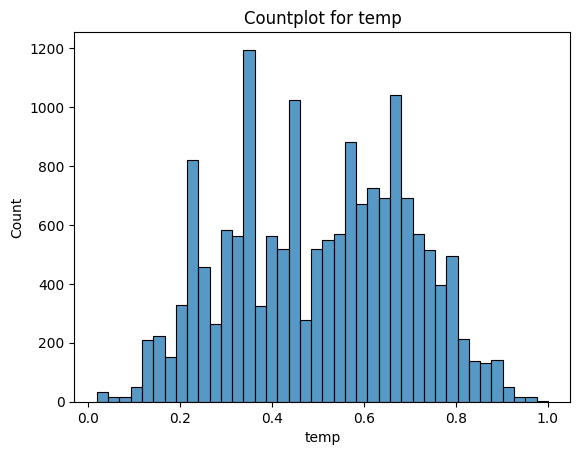

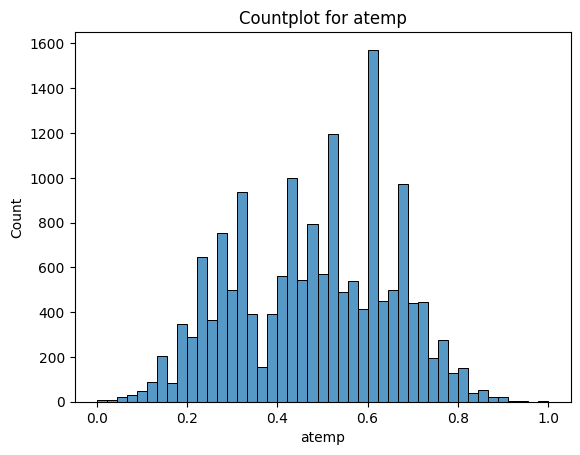

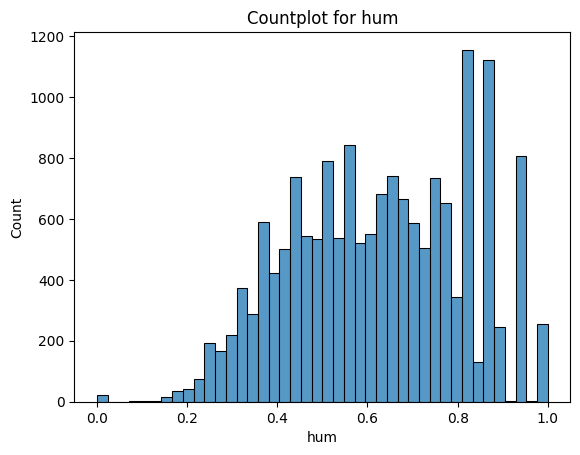

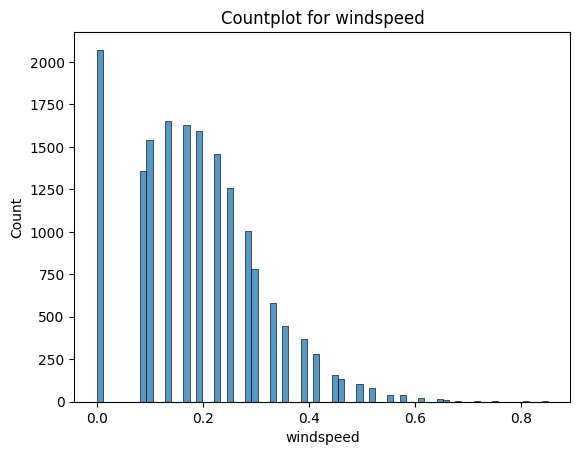

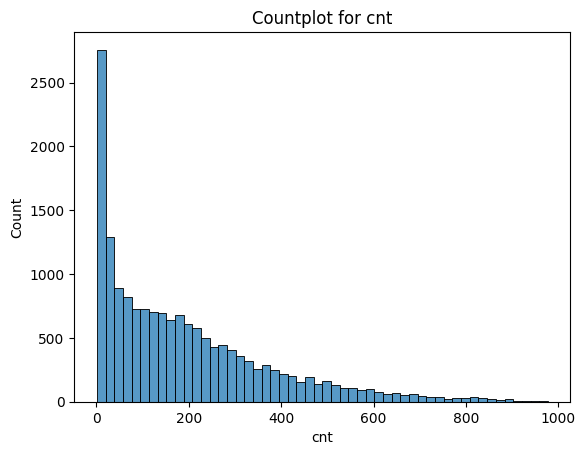

In [8]:
dv_train.plot_distribution(cols, 'train_data')

1. **Countplot for `holiday`:**
    - **Majority of entries are non-holidays**: The count for `0` (non-holidays) is significantly higher than `1` (holidays), indicating that most of the data represents regular working or non-holiday days.
2. **Countplot for `weathersit`:**
    - **Category 1 dominates**: Most observations fall into category `1`, representing favorable or clear weather.
    - **Category 2 and 3 are less common**: These represent moderate or less favorable weather conditions.
    - **Category 4 is absent**: These imply extreme weather conditions are not present in the dataset.
3. **Countplot for `temp`:**
    - This column is normally distributed.
4. **Countplot for `atemp`:**
    - This column is normally distributed.
5. **Countplot for `hum`:**
    - This column is left skewed.
6. **Countplot for `windspeed`:**
    - This column is right skewed.
7. **Countplot for `cnt`:**
    - Most of the amounts for cnt are nearer to zero, indicating that higher amounts for `cnt` are preserved for specific occassions.

## 2.3 Relationships between variables

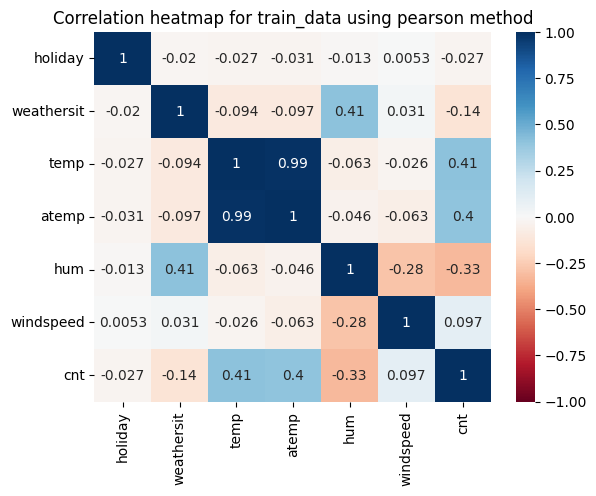

In [9]:
dv_train.plot_correlation('train_data', method='pearson')

The target variable `cnt` exhibits the following correlations with the other features in the dataset:

1. **`temp` (Temperature)**:
   - Correlation: **0.41** (moderate positive)
   - Interpretation: As temperature increases, the count of rentals tends to increase. This suggests that warmer weather is favorable for usage.

2. **`atemp` (Feels-like Temperature)**:
   - Correlation: **0.4** (moderate positive)
   - Interpretation: Similar to `temp`, higher feels-like temperatures are associated with more rentals. Since `temp` and `atemp` are highly correlated with each other, their impact on `cnt` is quite similar.

3. **`hum` (Humidity)**:
   - Correlation: **-0.33** (moderate negative)
   - Interpretation: Higher humidity levels are associated with a decrease in rentals. This indicates that humid weather may discourage people from renting.

4. **`windspeed`**:
   - Correlation: **0.097** (weak positive)
   - Interpretation: Windspeed shows a very weak positive correlation with rentals. This suggests that windspeed has a minimal linear relationship with the count of rentals.

5. **`weathersit` (Weather Situation)**:
   - Correlation: **-0.14** (weak negative)
   - Interpretation: Since this column is a column consisting of four classes, a pearson correlation coefficient is not the best way to figure out relations.

6. **`holiday`**:
   - Correlation: **-0.027** (very weak negative)
   - Interpretation: The correlation between holidays and rentals is negligible, indicating that the number of rentals is not significantly affected by whether it is a holiday. Although, here again it is a column consisting of two classes, therefore, a pearson correlation coefficient is not the best way to find out relations.

**Summary:**
- The most significant predictors of `cnt` are `temp` (0.41), `atemp` (0.4), and `hum` (-0.33), as these exhibit moderate correlations.
   - Since `temp` and `atemp` have a high correlation towards eachothter (0.99), one of them can be rendered negligible.
- Features such as `windspeed`, `weathersit`, and `holiday` show weak or negligible correlations, indicating they may have limited linear influence on the target variable.

## 2.4 Inspecting trends, and seasonal components

In [10]:
train_dc = fc.TimeSeriesDecomposer(train_data['cnt'])

In [11]:
trend, seasonal, residual = train_dc.decompose()

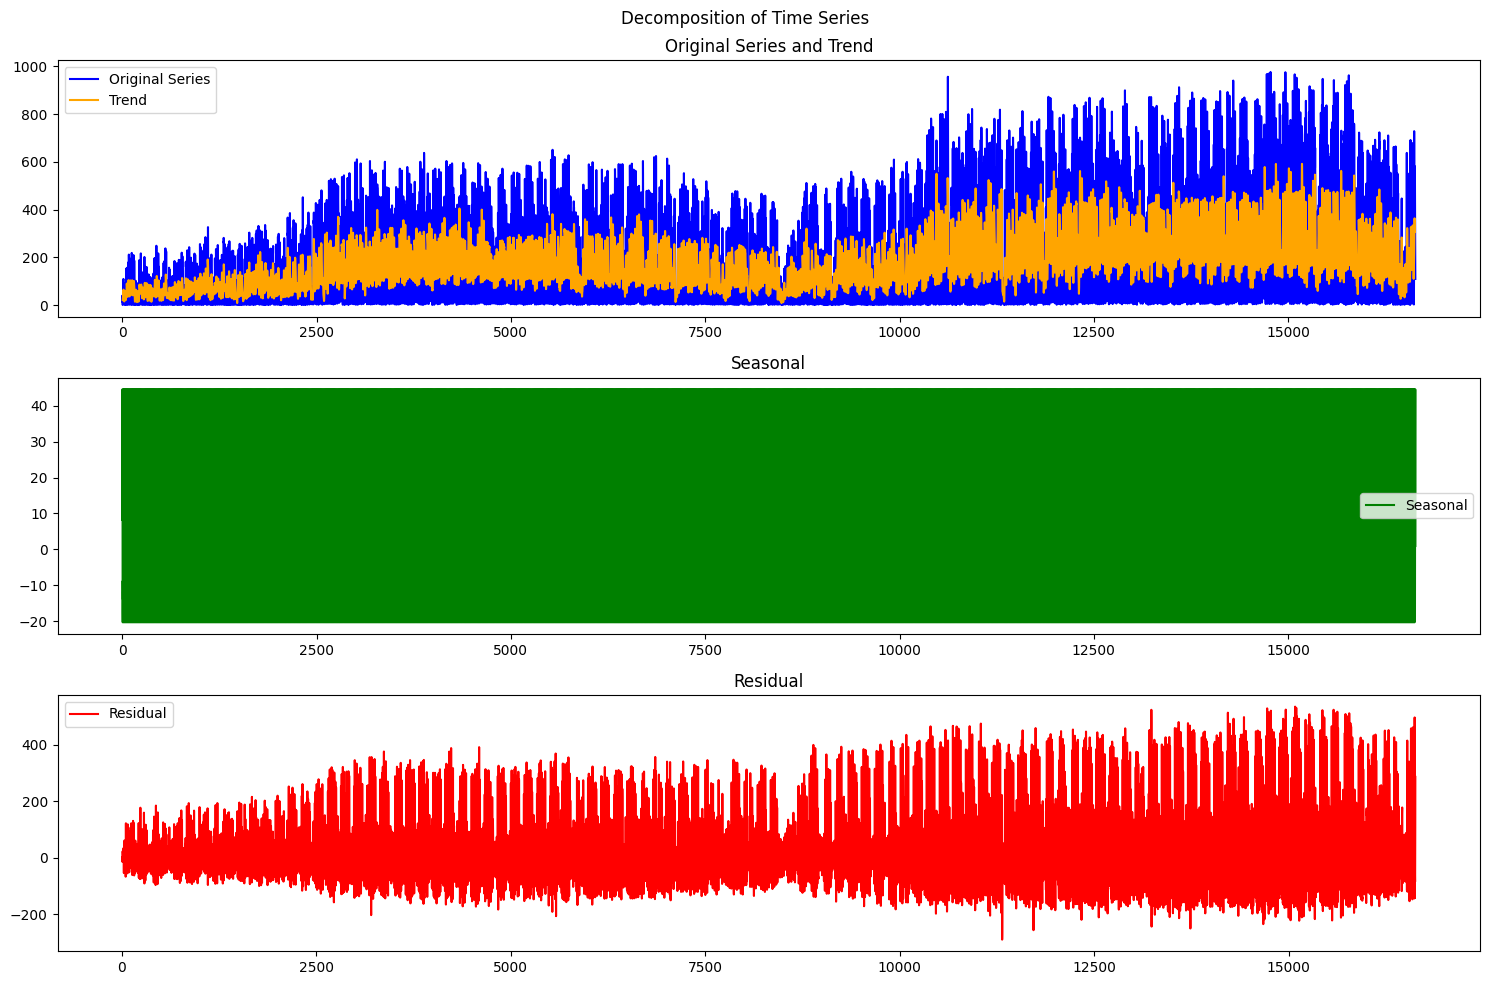

In [12]:
train_dc.plot_decomposition(trend, seasonal, residual)

The plot above does not clearly reveal a seasonally repeating pattern. This is likely due to the extensive amount of data, as it encompasses hourly observations over a two-year period. To facilitate the identification of seasonal patterns, a new decomposition will be performed on a subset comprising one-thirtysecond of the dataset.


In [13]:
train_dc_1 = fc.TimeSeriesDecomposer(train_data.loc[:len(train_data)/32, 'cnt'])

In [14]:
trend, seasonal, residual = train_dc_1.decompose()

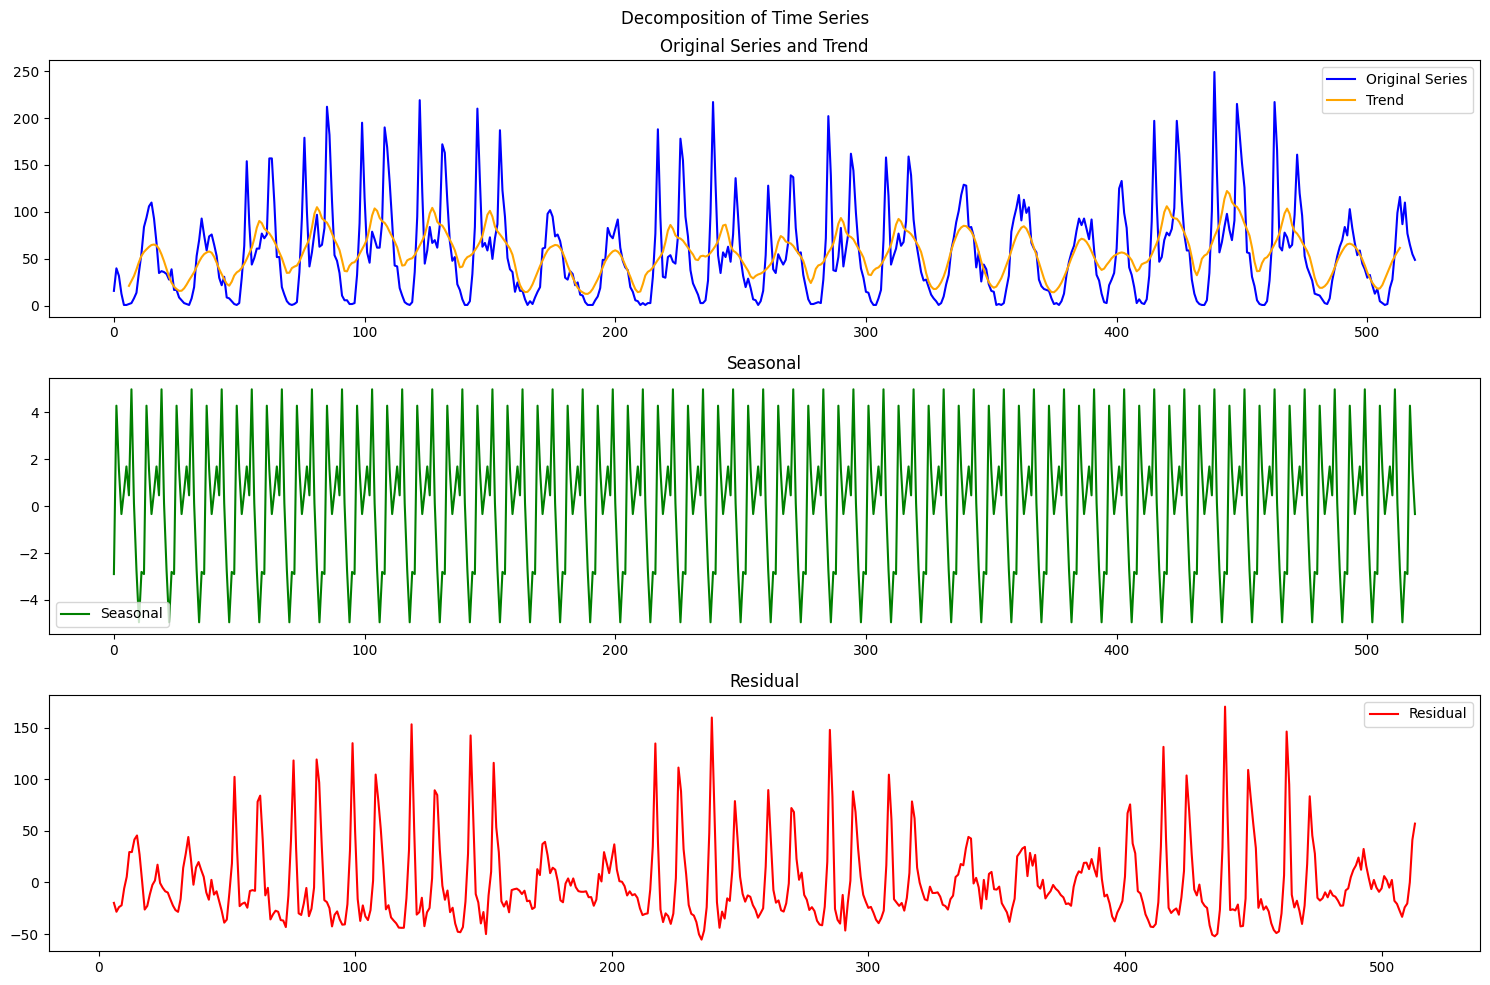

In [15]:
train_dc_1.plot_decomposition(trend, seasonal, residual)

The plot above reveals a distinct seasonal pattern, suggesting a potential temporal influence on the `cnt` variable.

## 2.5 Inspecting time specific relations

In [16]:
train_data = fc.create_timeseries_features(train_data)

In [17]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16637 entries, 0 to 16636
Data columns (total 14 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   date_hour    16637 non-null  datetime64[ns]
 1   holiday      16637 non-null  int64         
 2   weathersit   16637 non-null  int64         
 3   temp         16637 non-null  float64       
 4   atemp        16637 non-null  float64       
 5   hum          16637 non-null  float64       
 6   windspeed    16637 non-null  float64       
 7   cnt          16637 non-null  int64         
 8   year         16637 non-null  int64         
 9   month        16637 non-null  int64         
 10  week         16637 non-null  int64         
 11  day          16637 non-null  int64         
 12  hour         16637 non-null  int64         
 13  day_of_week  16637 non-null  int64         
dtypes: datetime64[ns](1), float64(4), int64(9)
memory usage: 1.8 MB


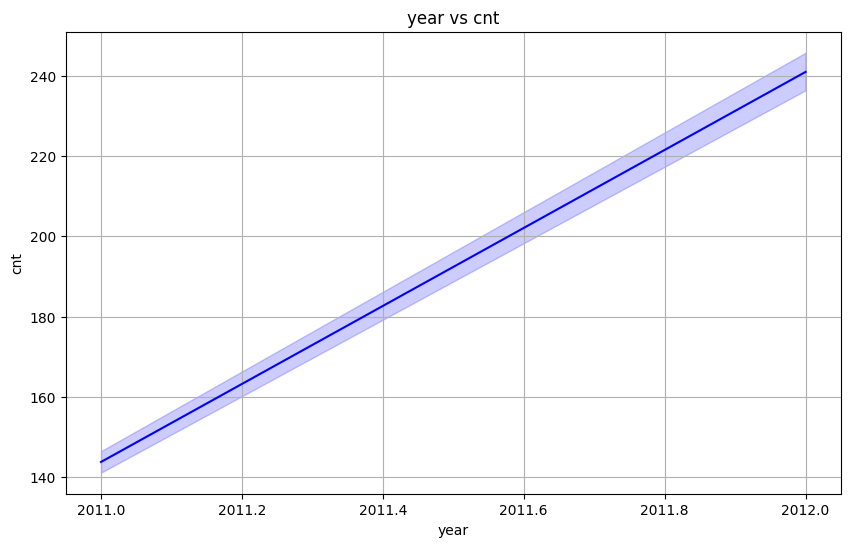

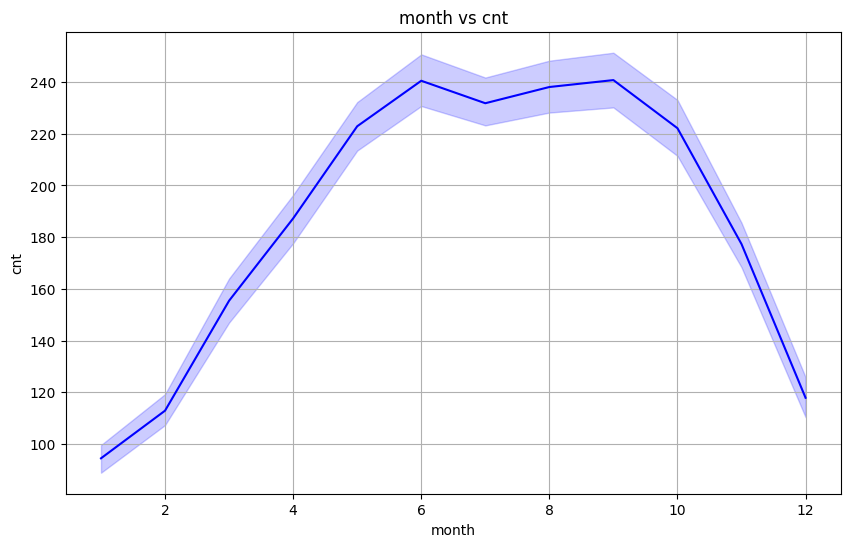

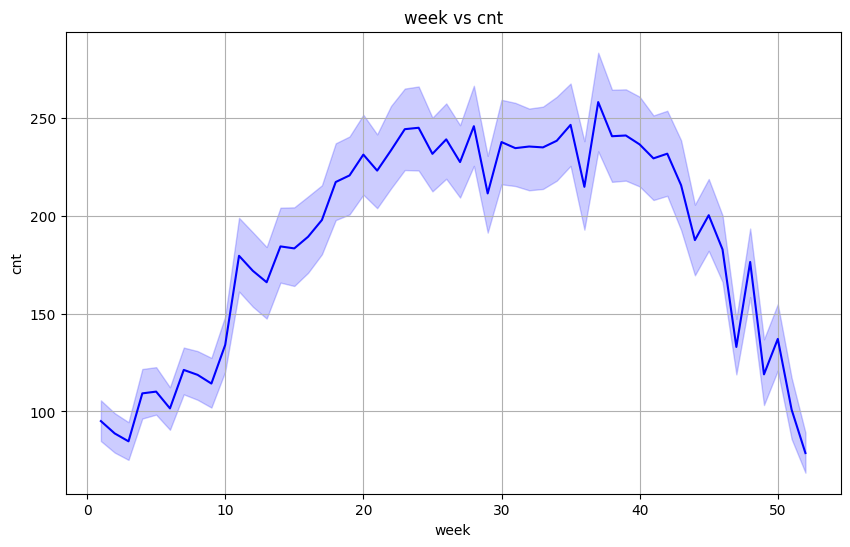

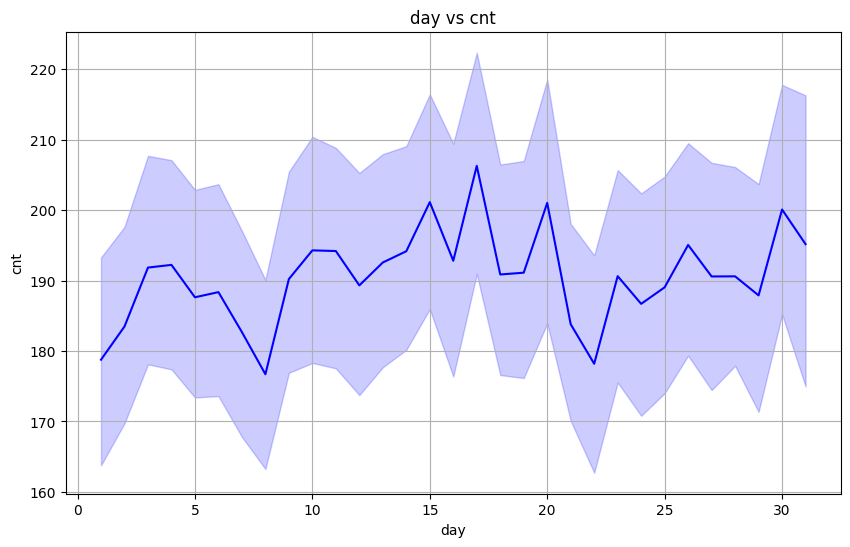

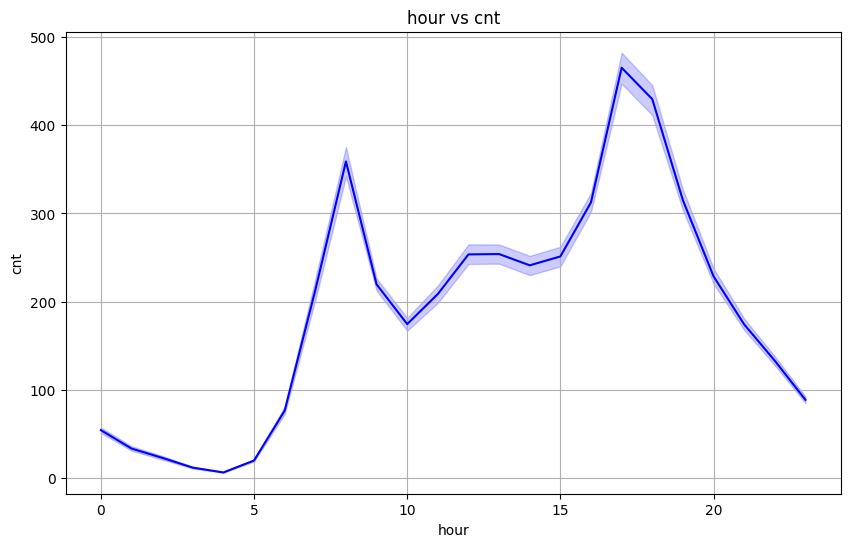

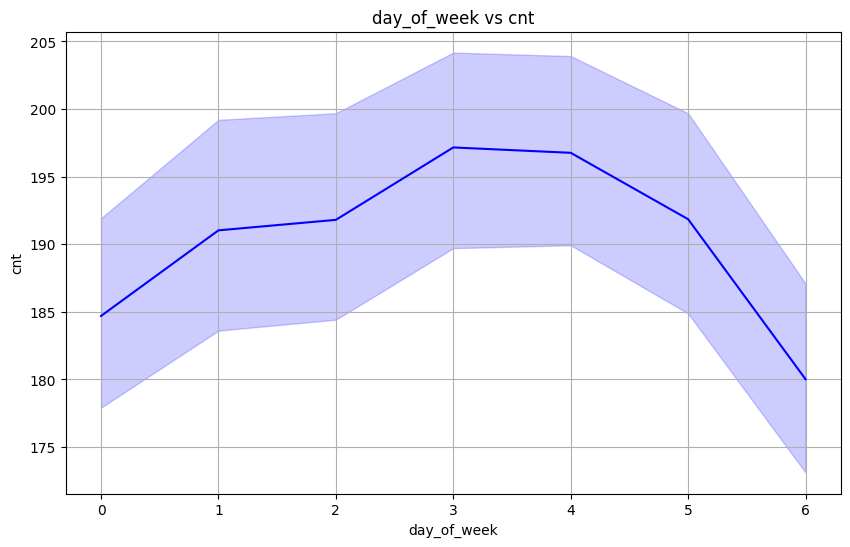

In [18]:
cols = ['year', 'month', 'week', 'day', 'hour', 'day_of_week']

for col in cols:
    dv_train.lineplot(x=col, y='cnt', title=f'{col} vs cnt', path=f'Figures/{col}_vs_cnt.png')

The analysis of the above plots reveals the following insights:  
- Over the two-year period, the average value of `cnt` has shown an upward trend. Since there is no real added value in this column since we are working over just two years, this column will be dropped  
- The monthly and weekly graphs demonstrate a distinct peak in `cnt` during the summer months. Since in both of the columns the same trends can be observed, the month column will be dropped.
- The day-of-the-month graph does not exhibit a clear correlation. Therefore, this column will be dropped.
- The hour-of-the-day graph shows pronounced peaks during the morning and evening hours.  
- The day-of-the-week graph indicates noticeable peaks on the fourth and fifth days of the week.

## 2.6 Conclusion

## 2.7 Application of conclusion

In [19]:
train_data = train_data.drop(['holiday', 'year', 'month', 'day', 'atemp', 'windspeed'], axis=1)

## 2.8 Changing `test_data`

In [20]:
test_data = fc.create_timeseries_features(test_data)

In [21]:
test_data = test_data.drop(['holiday', 'year', 'month', 'day', 'atemp', 'windspeed'], axis=1)

# 3. Feature engineering

## 3.1 Stationarity

To assess whether the dataset exhibits stationarity, we will perform the Augmented Dickey-Fuller (ADF) test. This statistical test evaluates the null hypothesis ($H_0$) that the data contains a unit root, indicating non-stationarity. Rejection of the null hypothesis suggests that the data is stationary.

**Hypothesis:**

- $H_0$: The data contains a unit root and is non-stationary.
- $H_1$: The data does not contain a unit root and is stationary.

**Results:**

The outcome of the ADF test includes:
- The test statistic, which is compared against critical values at various significance levels (e.g., 1%, 5%, 10%).
- The p-value, indicating the probability of observing the test statistic under the null hypothesis.

Based on these results, we will determine if stationarity can be assumed for the dataset or if additional transformations (e.g., differencing) are necessary to achieve stationarity.


In [22]:
stat_tests = fc.StatisticalTests(train_data)

In [23]:
stat_tests.stationary_test('cnt')

ADF Statistic: -6.625164793721716
p-value: 5.901288668679553e-09
Critical Values: {'1%': -3.430744160906401, '5%': -2.8617142032973706, '10%': -2.5668627239973634}
Reject the null hypothesis, the data is stationary


## 3.2 Fourier analysis

Peaks found at: [   2    4  692  694  700 1288 1387 1389 1485 1487 2079 2081 3465]
With amplitude: [67.34822877 30.04371046 84.48638012 84.06332976 21.60680841 36.79320207
 45.14943916 24.77695089 20.97976466 21.90916365 24.62657763 22.92395757
 21.75089858]


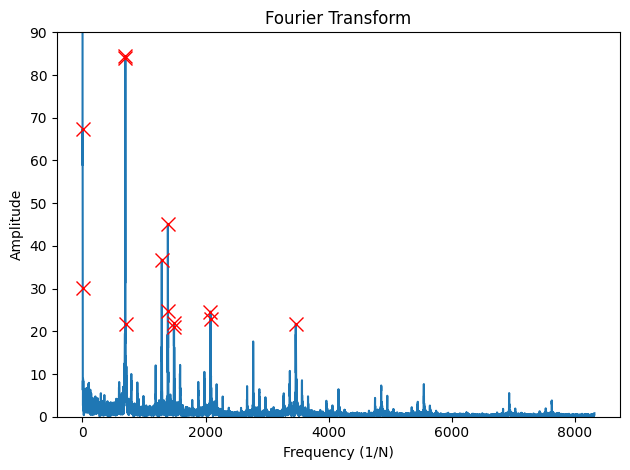

In [24]:
stat_tests.fourier_analysis('cnt')

The signal under analysis consists of multiple key periodic components distributed across different frequencies, with the most prominent peaks observed at approximately 692 Hz, 694 Hz, and 2 Hz. Higher frequency components, such as those at 1288 Hz and 2079 Hz, indicate finer details in the signal; however, their contributions are relatively minor. By applying a filtering process to remove peaks with amplitudes below the 20 threshold, the analysis effectively isolates the dominant frequencies. These frequencies are now primed for subsequent stages of signal processing, feature extraction, or machine learning modeling.

The results of this analysis indicate that the signal exhibits a complex structure characterized by periodic elements at various frequencies. Future work can now concentrate on these primary frequencies for deeper exploration or predictive modeling.


### 3.2.1 Inverted fourier transform

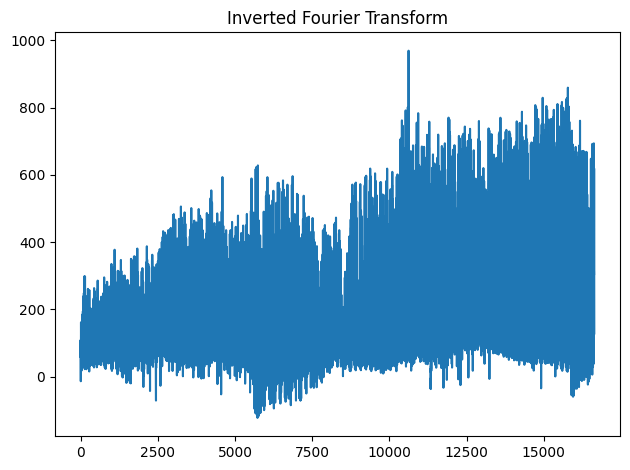

In [25]:
stat_tests.inverted_fourier_transform('cnt')

In [26]:
stat_tests.peaks

array([   2,    4,  692,  694,  700, 1288, 1387, 1389, 1485, 1487, 2079,
       2081, 3465], dtype=int64)

In [27]:
raise ValueError('The data is not stationary')

ValueError: The data is not stationary

## 3.3 Autocorrelation

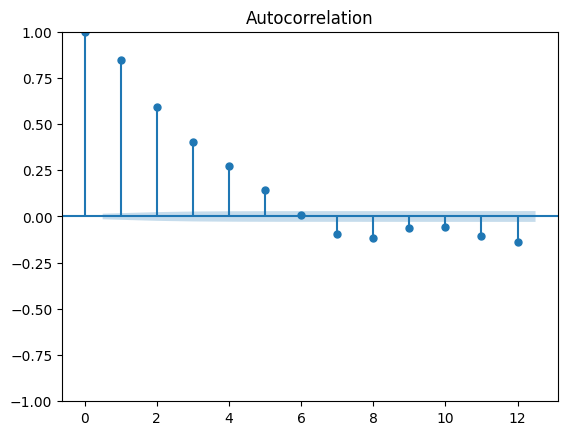

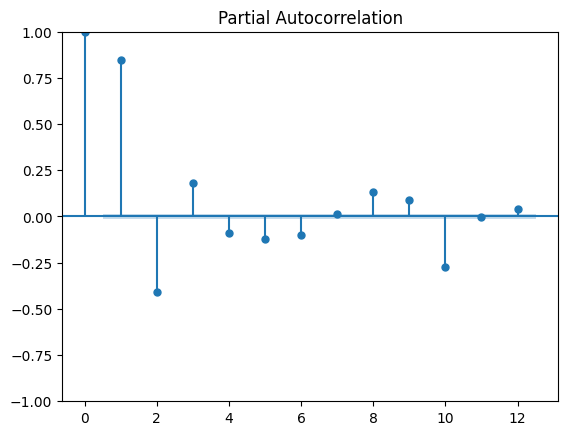

In [ ]:
plot_acf(train_data['cnt'], lags=12, ax=plt.gca(), alpha=0.05)
plt.savefig('Figures/ACF.png')
plt.show()

plot_pacf(train_data['cnt'], lags=12, ax=plt.gca(), alpha=0.05)
plt.savefig('Figures/PACF.png')
plt.show()

## 3.4 Scaling

ADD DESCRIPTION

In [ ]:
scaler = MinMaxScaler()

train_data[['day_of_week', 'hour', 'week']] = scaler.fit_transform(train_data[['day_of_week', 'hour', 'week']])
test_data[['day_of_week', 'hour', 'week']] = scaler.transform(test_data[['day_of_week', 'hour', 'week']])

## 3.5 Setting date as index

In [ ]:
train_data = train_data.set_index('date_hour')
test_data = test_data.set_index('date_hour')

# 4. Modelling

In [ ]:
models_dict = {'lr': (LinearRegression(), {'fit_intercept': [True, False]}),
               'knn': (KNeighborsRegressor(), {'n_neighbors': [3, 5], 'weights': ['uniform', 'distance']}),
               'dt': (DecisionTreeRegressor(), {'max_depth': [3, 5], 'min_samples_split': [4, 6], 'min_samples_leaf': [2, 3, 4]}),
               'rf': (RandomForestRegressor(), {'n_estimators': [50, 100], 'max_depth': [3, 5], 'min_samples_split': [4, 6], 'min_samples_leaf': [2, 3, 4]}),
               'xgb': (XGBRegressor(), {'n_estimators': [50, 100], 'max_depth': [3, 5], 'learning_rate': [0.01, 0.1, 0.3], 'subsample': [0.5, 0.7, 1], 'colsample_bytree': [0.5, 0.7, 1]})}

In [ ]:
modelling = fc.Modelling(train_data, test_data, models=models_dict)

for i in range(1, 3):
    modelling.det_proc(i)
    modelling.x_y_split('cnt')
    modelling.grid_search()
    modelling.fit_predict()
    modelling.write_to_csv(pred_col=test_data_pred_col, path_add=f'order_{i}')

lr - Best Params: {'fit_intercept': True} - Best Score: -106.92683786612582
knn - Best Params: {'n_neighbors': 3, 'weights': 'distance'} - Best Score: -87.6768046117505
dt - Best Params: {'max_depth': 11, 'max_features': 'log2', 'min_samples_leaf': 5, 'min_samples_split': 8} - Best Score: -65.79009551777698


KeyboardInterrupt: 